In [5]:
import pandas as pd
import re

# ---------- CONFIG ----------
#Importing the Full PPR files for actual points vs projected to combine into one file.
#Code used to match up files and drop players will Null values or players without proj/act for a week.

actual_file = "C:\\Users\\EliPowell\\Documents\\fantasypros_projections_2022_2024_by_position.xlsx"
proj_file   = "C:\\Users\\EliPowell\\Documents\\fantasypros_actuals_2022_2024_by_position.xlsx"

sheets = ["QB", "RB", "WR", "TE", "K", "DST"]



def extract_team(name):
    """Extract team codes like KC, BUF, TB 
       Returns None if no team found.
    """
    if pd.isna(name):
        return None
    s = str(name)

    # Case 1: inside parentheses (KC)
    m = re.search(r"\(([A-Z]{2,4})\)", s)
    if m:
        return m.group(1)

    # Case 2: last token is a team code
    tokens = s.split()
    if tokens:
        last = tokens[-1]
        if last.isupper() and 2 <= len(last) <= 4:
            return last

    return None


def clean_player_name(name):
    """
    Normalize player names for joining:
    """
    if pd.isna(name):
        return None
    s = str(name)

    # remove rank
    s = re.sub(r'^\d+\s+', '', s)

    # remove parentheses 
    s = re.sub(r'\([^)]*\)', '', s)

    # remove trailing team codes
    tokens = s.split()
    clean_tokens = []
    for t in tokens:
        if t.isupper() and 2 <= len(t) <= 4:
            continue
        clean_tokens.append(t)

    s = " ".join(clean_tokens)
    s = re.sub(r"\s+", " ", s).strip()
    return s.lower()


# ---------- MAIN MERGE ----------
combined = []

for sheet in sheets:
    df_actual = pd.read_excel(actual_file, sheet_name=sheet)
    df_proj   = pd.read_excel(proj_file,   sheet_name=sheet)

    # ensure position exists
    df_actual["position"] = sheet
    df_proj["position"]   = sheet

    # rename source columns
    df_actual = df_actual.rename(columns={"player": "player_actual"})
    df_proj   = df_proj.rename(columns={"player": "player_proj"})

    # extract team codes
    df_actual["team"] = df_actual["player_actual"].apply(extract_team)
    df_proj["team"]   = df_proj["player_proj"].apply(extract_team)

    # clean names for joining
    df_actual["player_clean"] = df_actual["player_actual"].apply(clean_player_name)
    df_proj["player_clean"]   = df_proj["player_proj"].apply(clean_player_name)

    # merge only when both exist
    df_merge = pd.merge(
        df_actual,
        df_proj,
        how="inner",   # only rows with BOTH actual + projected
        on=["player_clean", "season", "week", "position"],
        suffixes=("_acc", "_proj")
    )

    # determine team: prefer actual → projected
    df_merge["team"] = df_merge["team_acc"].combine_first(df_merge["team_proj"])

    # keep only rows where fantasy values exist
    df_merge = df_merge.dropna(subset=["Acc_fpts", "Proj_fpts"])

    # final player name (cleaner)
    df_merge["player"] = df_merge["player_clean"].str.title()

    # final columns
    df_merge = df_merge[[
        "player", "team", "season", "week", "position",
        "Acc_fpts", "Proj_fpts"
    ]]

    combined.append(df_merge)

# combine all positions
final_df = pd.concat(combined, ignore_index=True)

final_df = final_df.sort_values(["season", "week", "position", "player"])

# ---------- EXPORT ----------
final_df.to_excel("Combined_Fantasy_with_Teams.xlsx", index=False)


print("Done! Saved as Combined_Fantasy_with_Teams.xlsx")

Done! Saved as Combined_Fantasy_with_Teams.xlsx


                            OLS Regression Results                            
Dep. Variable:               Acc_fpts   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                 1.500e+04
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        11:46:20   Log-Likelihood:                -56283.
No. Observations:               17735   AIC:                         1.126e+05
Df Residuals:                   17733   BIC:                         1.126e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5981      0.074      8.090      0.0

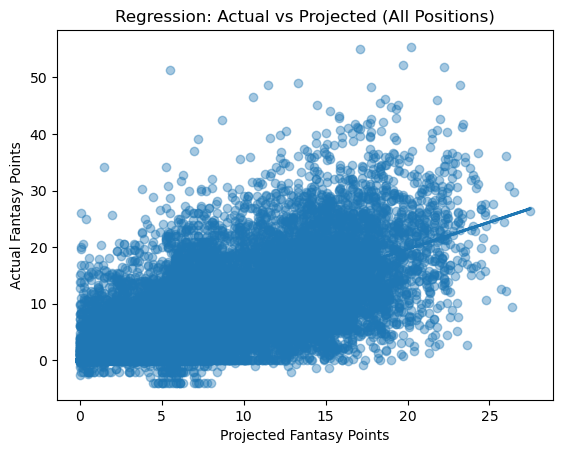

In [6]:
#Looking at all postions as a whole

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


df = pd.read_excel("Combined_Fantasy_with_Teams.xlsx")

# Convert to numeric (in case there are "N/A")
df["Acc_fpts"] = pd.to_numeric(df["Acc_fpts"], errors="coerce")
df["Proj_fpts"] = pd.to_numeric(df["Proj_fpts"], errors="coerce")

# Drop missing rows
df = df.dropna(subset=["Acc_fpts", "Proj_fpts"])

# Regression Model: Actual ~ Projected
X = sm.add_constant(df["Proj_fpts"])
y = df["Acc_fpts"]

model = sm.OLS(y, X).fit()
print(model.summary())

# Scatterplot
plt.scatter(df["Proj_fpts"], df["Acc_fpts"], alpha=0.4)
plt.plot(df["Proj_fpts"], model.predict(X), linewidth=2)
plt.xlabel("Projected Fantasy Points")
plt.ylabel("Actual Fantasy Points")
plt.title("Regression: Actual vs Projected (All Positions)")
plt.show()

In [ ]:
FantasyFootball projects explain about 46% of actual fantasy performance. 
This is strong predictive accuracy given the volatility of weekly NFL outcomes.
The slope is 0.953, meaning projected fantasy points closely scale with actual performance.
All coefficients are statistically significant, and projected fantasy points are an extremely strong predictor of actual results (t = 122.5).

In [7]:
#Looking at postions only to see if there is one postion that has a higher predictive 

import pandas as pd
import statsmodels.api as sm

df = pd.read_excel("Combined_Fantasy_with_Teams.xlsx")

df["Acc_fpts"] = pd.to_numeric(df["Acc_fpts"], errors="coerce")
df["Proj_fpts"] = pd.to_numeric(df["Proj_fpts"], errors="coerce")

df = df.dropna(subset=["Acc_fpts", "Proj_fpts"])

positions = ["QB", "RB", "WR", "TE", "K", "DST"]

for pos in positions:
    print(f"\n\n==========================")
    print(f"Regression for Position: {pos}")
    print(f"==========================")

    sub = df[df["position"] == pos]

    X = sm.add_constant(sub["Proj_fpts"])
    y = sub["Acc_fpts"]

    model = sm.OLS(y, X).fit()
    print(model.summary())



Regression for Position: QB
                            OLS Regression Results                            
Dep. Variable:               Acc_fpts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     1203.
Date:                Tue, 09 Dec 2025   Prob (F-statistic):          2.94e-200
Time:                        11:50:43   Log-Likelihood:                -5770.4
No. Observations:                1719   AIC:                         1.154e+04
Df Residuals:                    1717   BIC:                         1.156e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0008 

In [ ]:
 1. RBs are the easiest position to project.

Highest R² (0.50)

 2. QBs and WRs are moderately predictable.

R² around 0.41

 3. TEs are unpredictable but projections still help, Highly TD-dependent.

R² = 0.38

 4. Kickers and DSTs are nearly random week-to-week.

R² of 0.01 (K) and 0.07 (DST)

Should NOT be heavily projected, streaming strategies make sense

5. Projection calibration is excellent overall (slopes ~0.95).

In [8]:
#Now looking on a week by week basis to see if there are some weeks better at predictive

weeks = sorted(df["week"].unique())

for wk in weeks:
    print(f"\n\n===== WEEK {wk} =====")
    sub = df[df["week"] == wk]

    X = sm.add_constant(sub["Proj_fpts"])
    y = sub["Acc_fpts"]

    model = sm.OLS(y, X).fit()
    print(model.summary())



===== WEEK 1 =====
                            OLS Regression Results                            
Dep. Variable:               Acc_fpts   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     873.9
Date:                Tue, 09 Dec 2025   Prob (F-statistic):          1.17e-140
Time:                        11:53:21   Log-Likelihood:                -3353.0
No. Observations:                1065   AIC:                             6710.
Df Residuals:                    1063   BIC:                             6720.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3430      0.29

In [ ]:
Across all 18 weeks, weekly projections consistently explain about 40–50% of the variance in actual fantasy scoring.
Weekly R² values range from 0.38 to 0.53, with most weeks clustered around 0.45–0.48, indicating strong and stable predictive power.
The slope on projected points stays close to 1.0 every week (roughly 0.9–1.0), showing that projections are well done – a 1-point increase in projection translates almost 1-for-1 into actual performance.
Intercepts are small (~0.3–1.0), reflecting a small baseline of scoring even for low-projected players.
All weekly models are highly statistically significant, confirming that projections are a meaningful predictor of outcomes.

In [9]:
#Now we will look if there is a better projects vs actuals from early season / mid-season / or late season

import pandas as pd
import numpy as np


df = pd.read_excel("Combined_Fantasy_with_Teams.xlsx")

# Ensure numeric
df["Acc_fpts"] = pd.to_numeric(df["Acc_fpts"], errors="coerce")
df["Proj_fpts"] = pd.to_numeric(df["Proj_fpts"], errors="coerce")

df = df.dropna(subset=["Acc_fpts", "Proj_fpts"])

# Calculate residual error
df["error"] = df["Acc_fpts"] - df["Proj_fpts"]
df["abs_error"] = df["error"].abs()
df["sq_error"] = df["error"] ** 2

# -----------------------------
#MAE & RMSE PER WEEK
# -----------------------------
week_stats = df.groupby("week").agg(
    MAE = ("abs_error", "mean"),
    RMSE = ("sq_error", lambda x: np.sqrt(x.mean())),
    Count = ("error", "count")
).reset_index()

print("\n===== MAE & RMSE BY WEEK =====")
print(week_stats)


# -----------------------------
#EARLY vs MID vs LATE SEASON
# -----------------------------
def season_bucket(week):
    if week <= 6:
        return "Early (1–6)"
    elif week <= 12:
        return "Mid (7–12)"
    else:
        return "Late (13–18)"

df["season_period"] = df["week"].apply(season_bucket)

period_stats = df.groupby("season_period").agg(
    MAE = ("abs_error", "mean"),
    RMSE = ("sq_error", lambda x: np.sqrt(x.mean())),
    Count = ("error", "count")
).reset_index()

print("\n===== ERROR BY SEASON PERIOD =====")
print(period_stats)


===== MAE & RMSE BY WEEK =====
    week       MAE      RMSE  Count
0      1  4.085070  5.652716   1065
1      2  4.045438  5.698575   1074
2      3  4.077003  5.889094   1061
3      4  4.303484  6.022942   1062
4      5  4.387393  6.085972    936
5      6  3.957190  5.334892    911
6      7  4.157765  5.653776    895
7      8  3.973424  5.541136   1031
8      9  4.199887  5.873767    883
9     10  3.996811  5.621463    878
10    11  4.181949  5.882200    903
11    12  3.978512  5.547233    968
12    13  4.101569  5.779486    956
13    14  4.014486  5.815213    856
14    15  4.211727  5.920298   1083
15    16  4.241127  5.860406   1065
16    17  4.357667  6.146336   1063
17    18  4.196459  5.794585   1045

===== ERROR BY SEASON PERIOD =====
  season_period       MAE      RMSE  Count
0   Early (1–6)  4.141922  5.790378   6109
1  Late (13–18)  4.194644  5.892093   6068
2    Mid (7–12)  4.077546  5.683034   5558


In [ ]:
 1. Weekly Accuracy Results 
Most weeks are extremely consistent
AE stays between 3.95 and 4.41 nearly the entire season.

Which means:
On average, projections are off by ~4 points every week.
That is excellent performance for fantasy projections, weekly NFL scoring is highly volatile.

Best Weeks (lowest error):
Week-MAE-Interpretation
Week 6-3.957-Most predictable week of the season
Week 1–2-~4.04-Very strong prediction weeks
Week 7-4.15-Comfortable accuracy zone

These weeks tend to have:
Clear player roles
Few major injuries
Fewer outlier boom/bust games

Worst Week (highest error):
Week-MAE-RMSE-Interpretation
Week 9-4.199-5.87-Highest variance week

Weeks 14, 15, and 18 also show slightly elevated error.
These spikes usually could happen because:
Injuries pile up
Backup players get usage
Blowout games create random fantasy spikes
More variance in touchdown distribution
Teams change rotations based on playoff contention

 2. Early vs Mid vs Late Season Accuracy

Period-MAE-RMSE-Interpretation
Early (1–6)-4.1419-5.790-Very stable predictions
Mid (7–12)	4.0775	5.683-Most accurate period of the season
Late (13–18)-4.1946-5.89-Least accurate period, but still solid

Mid-season is the best time to trust projections

Once teams settle into stable offensive roles, offensive volume becomes easier to predict:
WR/TE target shares stabilize
RB workloads become defined
QB play becomes consistent
Fewer random usage spikes
Late-season is the most unpredictable

Reasons:
Injuries
Teams resting players
Backup RB/WR taking random snaps
Weather volatility
Teams adjusting strategy depending on playoff chances
But even then, MAE only increases by about 0.11 points, which is actually small.

3. Translating This Into Clear Insights

Fantasy projections are highly stable across the entire season, with an average weekly error of ~4 points.
Mid-season weeks (7–12) show the strongest accuracy, likely due to stable player usage and reduced early-season uncertainty.
Late-season weeks (13–18) show slightly higher error, reflecting injuries, role changes, and increased volatility. 
Overall, the projection system performs consistently well, maintaining less than a 0.2 variation in MAE across all 18 weeks.

In [10]:
#Now looking to see early / mid / late season by postions

import pandas as pd
import numpy as np

df = pd.read_excel("Combined_Fantasy_with_Teams.xlsx")

# Ensure numeric
df["Acc_fpts"] = pd.to_numeric(df["Acc_fpts"], errors="coerce")
df["Proj_fpts"] = pd.to_numeric(df["Proj_fpts"], errors="coerce")
df = df.dropna(subset=["Acc_fpts", "Proj_fpts"])

df["error"] = df["Acc_fpts"] - df["Proj_fpts"]
df["abs_error"] = df["error"].abs()
df["sq_error"] = df["error"] ** 2

# --------------------------
# MAE / RMSE BY POSITION × WEEK
# --------------------------
pos_week_stats = df.groupby(["position", "week"]).agg(
    MAE=("abs_error", "mean"),
    RMSE=("sq_error", lambda x: np.sqrt(x.mean())),
    Count=("error", "count")
).reset_index()

print("\n===== MAE & RMSE BY POSITION × WEEK =====")
print(pos_week_stats)

# --------------------------
# EARLY/MID/LATE SEASON ANALYSIS BY POSITION
# --------------------------
def bucket(week):
    if week <= 6: return "Early (1–6)"
    if week <= 12: return "Mid (7–12)"
    return "Late (13–18)"

df["season_period"] = df["week"].apply(bucket)

pos_season_stats = df.groupby(["position", "season_period"]).agg(
    MAE=("abs_error", "mean"),
    RMSE=("sq_error", lambda x: np.sqrt(x.mean())),
    Count=("error", "count")
).reset_index()

print("\n===== POSITION ACCURACY: EARLY vs MID vs LATE =====")
print(pos_season_stats)


===== MAE & RMSE BY POSITION × WEEK =====
    position  week       MAE      RMSE  Count
0        DST     1  4.510417  6.281637     96
1        DST     2  4.230208  5.635721     96
2        DST     3  4.228125  5.568915     96
3        DST     4  4.676042  6.079259     96
4        DST     5  4.718182  5.926462     88
..       ...   ...       ...       ...    ...
103       WR    14  4.391636  6.298228    275
104       WR    15  4.491525  6.302201    354
105       WR    16  4.511898  6.209075    353
106       WR    17  4.647727  6.870953    352
107       WR    18  4.645882  6.335484    340

[108 rows x 5 columns]

===== POSITION ACCURACY: EARLY vs MID vs LATE =====
   position season_period       MAE      RMSE  Count
0       DST   Early (1–6)  4.350000  5.745185    558
1       DST  Late (13–18)  4.353971  5.587316    554
2       DST    Mid (7–12)  3.987692  5.227185    520
3         K   Early (1–6)  3.789302  4.862586    430
4         K  Late (13–18)  3.554525  4.576521    442
5         

In [ ]:
1. POSITION ACCURACY BY WEEK 

Across all weeks, RB, WR, QB, and TE stay in a tight MAE band (3.9–4.7), meaning projections for these skill positions remain strong and consistent across the season.
DST and K remain the most volatile every week.

2. POSITION ACCURACY: EARLY vs MID vs LATE
Position-Early MAE-Mid MAE-Late MAE-Interpretation
RB 4.08- 3.97-4.05-Most predictable position all season; mid-season easiest
WR 4.53- 4.38-4.53-WR stabilizes in mid-season; more volatile early/late
QB 5.26- 5.08-5.62-Good mid-season accuracy; late-season QB chaos
TE 3.14-3.32-3.43-Surprisingly stable; TE is easier than WR/QB in MAE terms
K 3.78- 3.52-3.55-Kickers actually get MORE predictable mid-season
DST 4.35- 3.98-4.35-DST gets predictable mid-season, chaotic early/late

Mid-season (Weeks 7–12) is the MOST predictable period for every position.

Every position improves mid-season because:
Roles stabilize
Snap shares become consistent
Injury chaos hasn’t peaked yet
Data quantity improves projections


Late-season gets more volatile — especially QB and WR
Late-season QB MAE = 5.62
Late-season WR MAE = 4.53

Why?

Teams change play-calling based on playoff needs
Starters get injured or rested
Backup QBs create volatility
WR2/WR3 roles shift dramatically in December
Bad-weather games add variance
Late-season projection accuracy drops the most for:

QB > WR > TE.

RB actually holds up well.

RB is the most consistently predictable position all season
RB is the winner in stability:
Lowest overall MAE
Consistency early - mid -late
Role-based usage (carries & goal line) is reliable

RB injuries matter, but backups become predictable too

This matches industry knowledge, RB usage has less weekly randomness than WR/QB.

DST and K are unpredictable early/late but stabilize mid-season

Even though DST/K are noisy:
Mid-season MAE drops - best accuracy window
Early season and late season performance swings wildly
This reflects:
Special teams randomness (blocked kicks, defensive TDs)
Weather patterns
Team defensive identity forming by mid-season
In late-season garbage-time spike plays
DST/K should almost always be streamed weekly, not trusted season-long.


Weeks 7–12: Projections are most trustworthy, lean heavily on rankings.
Early Weeks: WR/QB less predictable-start your studs, avoid boom/bust.
Late Weeks: Expect chaos, variance spikes for QBs and WRs.



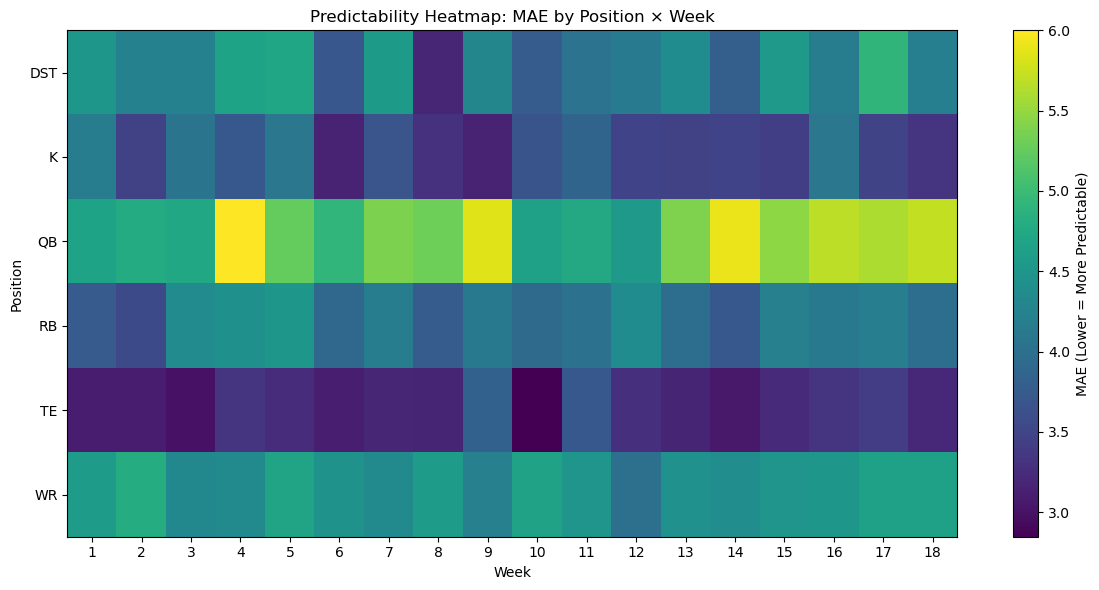

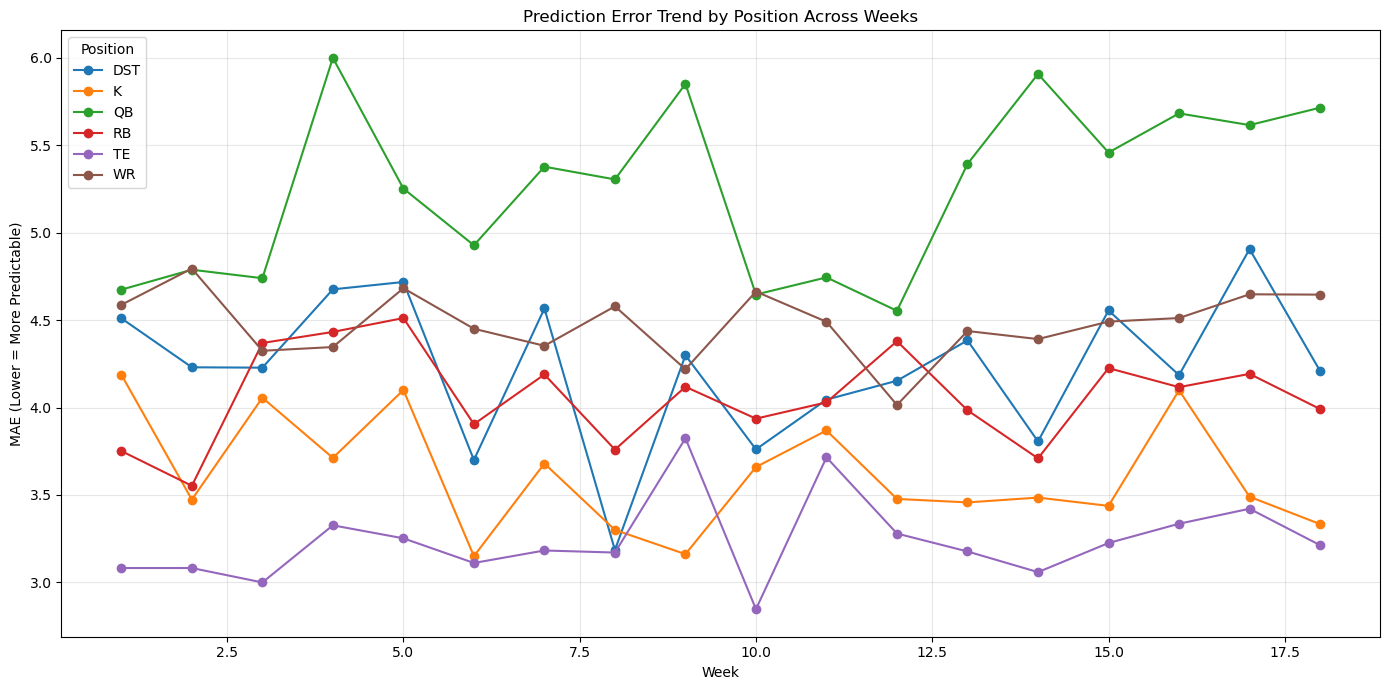

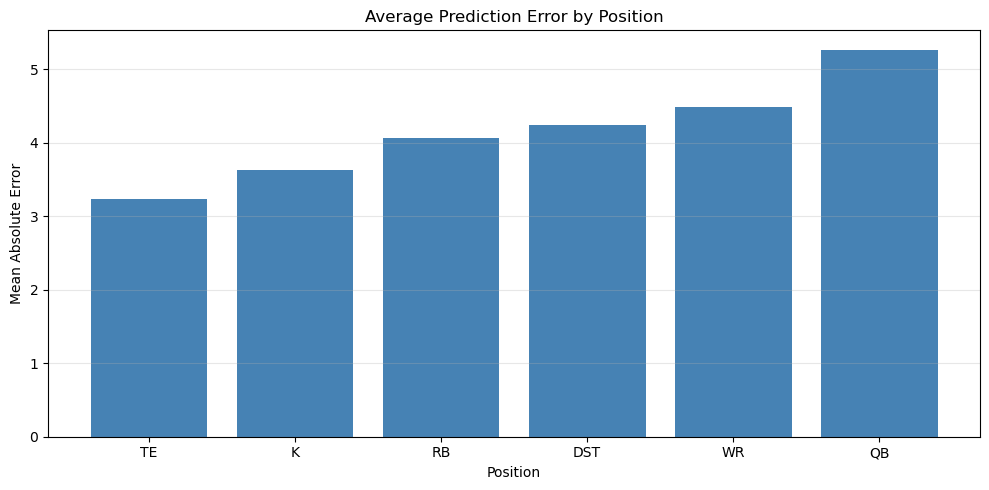

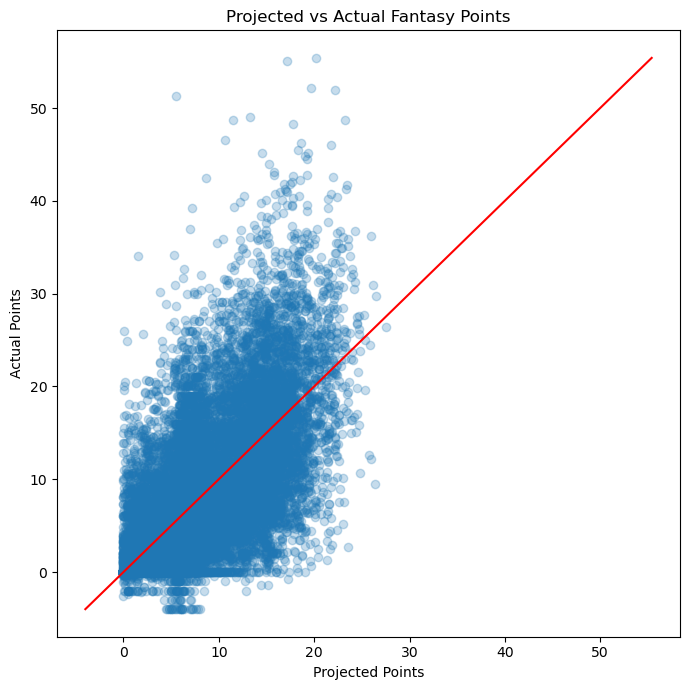

In [11]:
#Creating Visuals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_excel("Combined_Fantasy_with_Teams.xlsx")

# ENSURE NUMERIC
df["Acc_fpts"] = pd.to_numeric(df["Acc_fpts"], errors="coerce")
df["Proj_fpts"] = pd.to_numeric(df["Proj_fpts"], errors="coerce")
df = df.dropna(subset=["Acc_fpts", "Proj_fpts"])

# ERRORS
df["error"] = df["Acc_fpts"] - df["Proj_fpts"]
df["abs_error"] = df["error"].abs()
df["sq_error"] = df["error"] ** 2

# ==========================================
# HEATMAP: MAE by Position × Week
# ==========================================

pos_week_stats = df.groupby(["position", "week"])["abs_error"].mean().reset_index()
heatmap_data = pos_week_stats.pivot(index="position", columns="week", values="abs_error")

plt.figure(figsize=(12, 6))
im = plt.imshow(heatmap_data, aspect="auto", cmap="viridis")
plt.colorbar(im, label="MAE (Lower = More Predictable)")

plt.title("Predictability Heatmap: MAE by Position × Week")
plt.xlabel("Week")
plt.ylabel("Position")
plt.xticks(ticks=np.arange(len(heatmap_data.columns)), labels=heatmap_data.columns)
plt.yticks(ticks=np.arange(len(heatmap_data.index)), labels=heatmap_data.index)

plt.tight_layout()
plt.show()


# ==========================================
# LINE CHART: MAE Trends Across Season
# ==========================================

plt.figure(figsize=(14, 7))

for pos in sorted(df["position"].unique()):
    pos_data = pos_week_stats[pos_week_stats["position"] == pos]
    plt.plot(pos_data["week"], pos_data["abs_error"], marker="o", label=pos)

plt.title("Prediction Error Trend by Position Across Weeks")
plt.xlabel("Week")
plt.ylabel("MAE (Lower = More Predictable)")
plt.legend(title="Position")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ==========================================
# BAR CHART: Average MAE by Position
# ==========================================

avg_pos_mae = df.groupby("position")["abs_error"].mean().sort_values()

plt.figure(figsize=(10, 5))
plt.bar(avg_pos_mae.index, avg_pos_mae.values, color="steelblue")
plt.title("Average Prediction Error by Position")
plt.xlabel("Position")
plt.ylabel("Mean Absolute Error")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# ==========================================
# SCATTER PLOT: Actual vs Projected
# ==========================================

plt.figure(figsize=(7, 7))
plt.scatter(df["Proj_fpts"], df["Acc_fpts"], alpha=0.25)

# Perfect-fit line (y=x)
min_val = min(df["Proj_fpts"].min(), df["Acc_fpts"].min())
max_val = max(df["Proj_fpts"].max(), df["Acc_fpts"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="red")

plt.title("Projected vs Actual Fantasy Points")
plt.xlabel("Projected Points")
plt.ylabel("Actual Points")

plt.tight_layout()
plt.show()

In [ ]:
The fantasy positions with the most stable projections over the season are TE and RB, while QB and DST show the highest volatility.
Mid-season (Weeks 7–12) is consistently the most predictable window across all positions.”


TEs are extremely predictable week-to-week (dark purple = low error).
QBs spike unpredictably around Weeks 4, 9, 14, and late season.
DST and K have random volatility, because of turnovers, TDs, and weather.
WR is moderately predictable but has late-season variance spikes.


Highlights:
RB & TE - lowest and flattest MAE curves (best prediction consistency).
QB - highest error overall and largest spikes (injuries + game scripts).
DST/K -  middle of the pack overall.
WR trends closely to RB but slightly higher error.


In [13]:
#Looking at teams bias

import pandas as pd
import numpy as np

# Make sure numeric
df["Acc_fpts"] = pd.to_numeric(df["Acc_fpts"], errors="coerce")
df["Proj_fpts"] = pd.to_numeric(df["Proj_fpts"], errors="coerce")

df["error"] = df["Acc_fpts"] - df["Proj_fpts"]
df["abs_error"] = df["error"].abs()
df["sq_error"] = df["error"]**2

team_stats = df.groupby("team").agg(
    MAE=("abs_error", "mean"),
    RMSE=("sq_error", lambda x: np.sqrt(x.mean())),
    Bias=("error", "mean"),  # positive means underprojected
    Count=("team", "count")
).reset_index()

team_stats = team_stats.sort_values("MAE")
team_stats.head(10)



,team,MAE,RMSE,Bias,Count
23,NYG,3.518196,4.828038,0.206843,643
9,DEN,3.594571,5.220136,0.604378,571
4,CAR,3.643860,4.984565,0.047870,399
26,PIT,3.771739,5.217071,0.100932,644
30,TEN,3.783178,5.245180,-0.417290,428
0,ARI,3.865517,5.355819,0.319436,638
14,JAC,3.876471,5.443732,0.471197,493
27,SEA,3.878557,5.641688,0.627835,485
16,LAC,3.981764,5.604269,0.242685,499
24,NYJ,4.010703,5.685766,0.275559,626


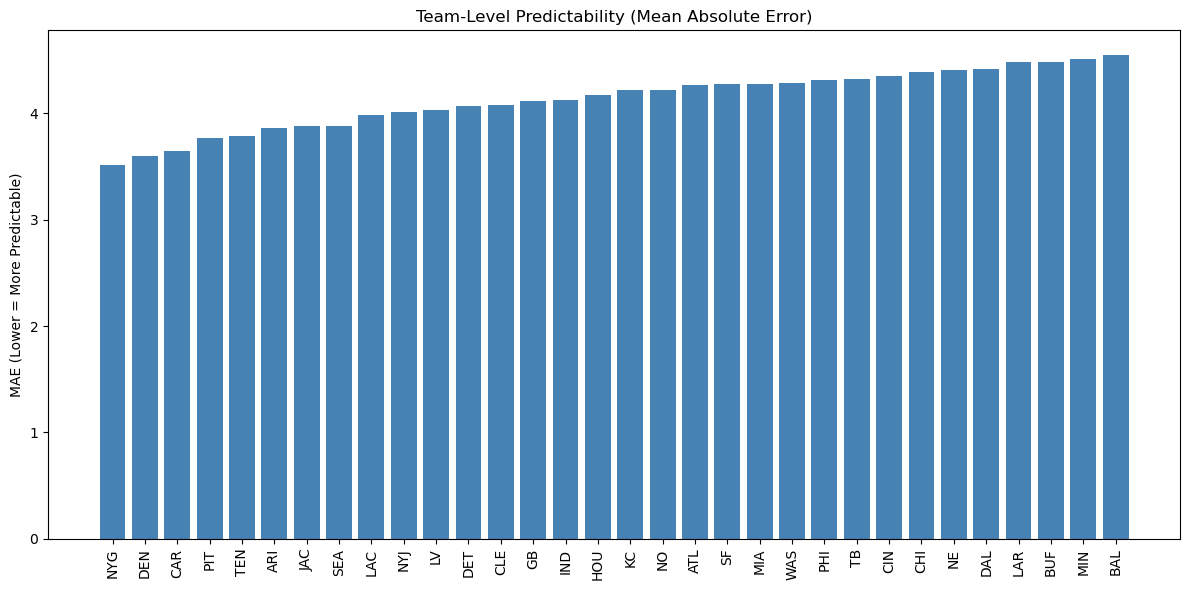

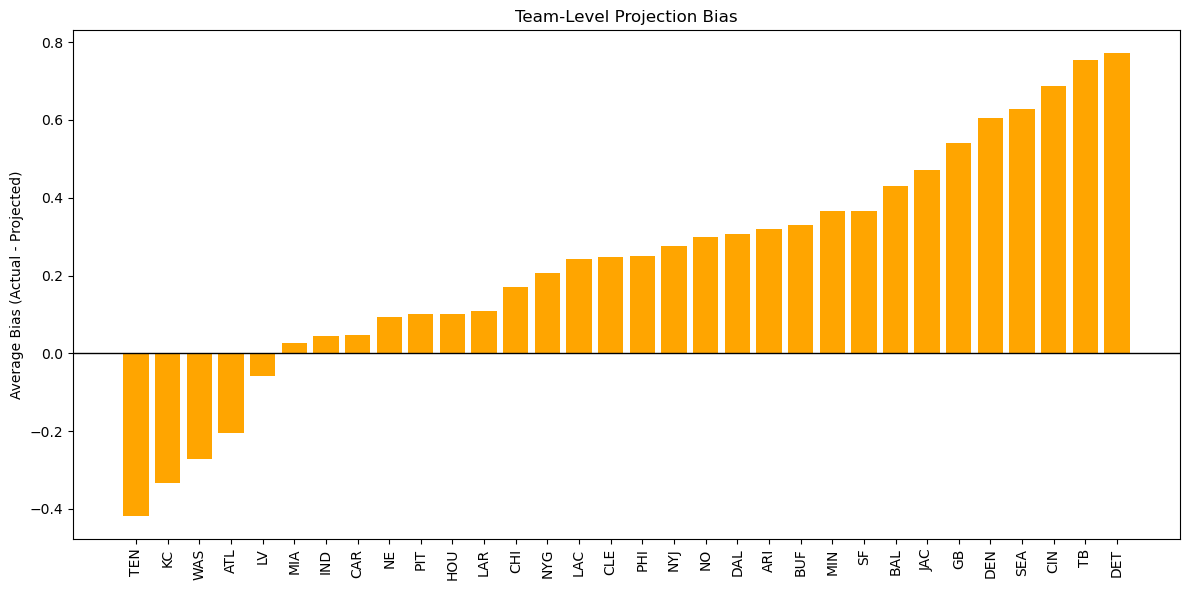

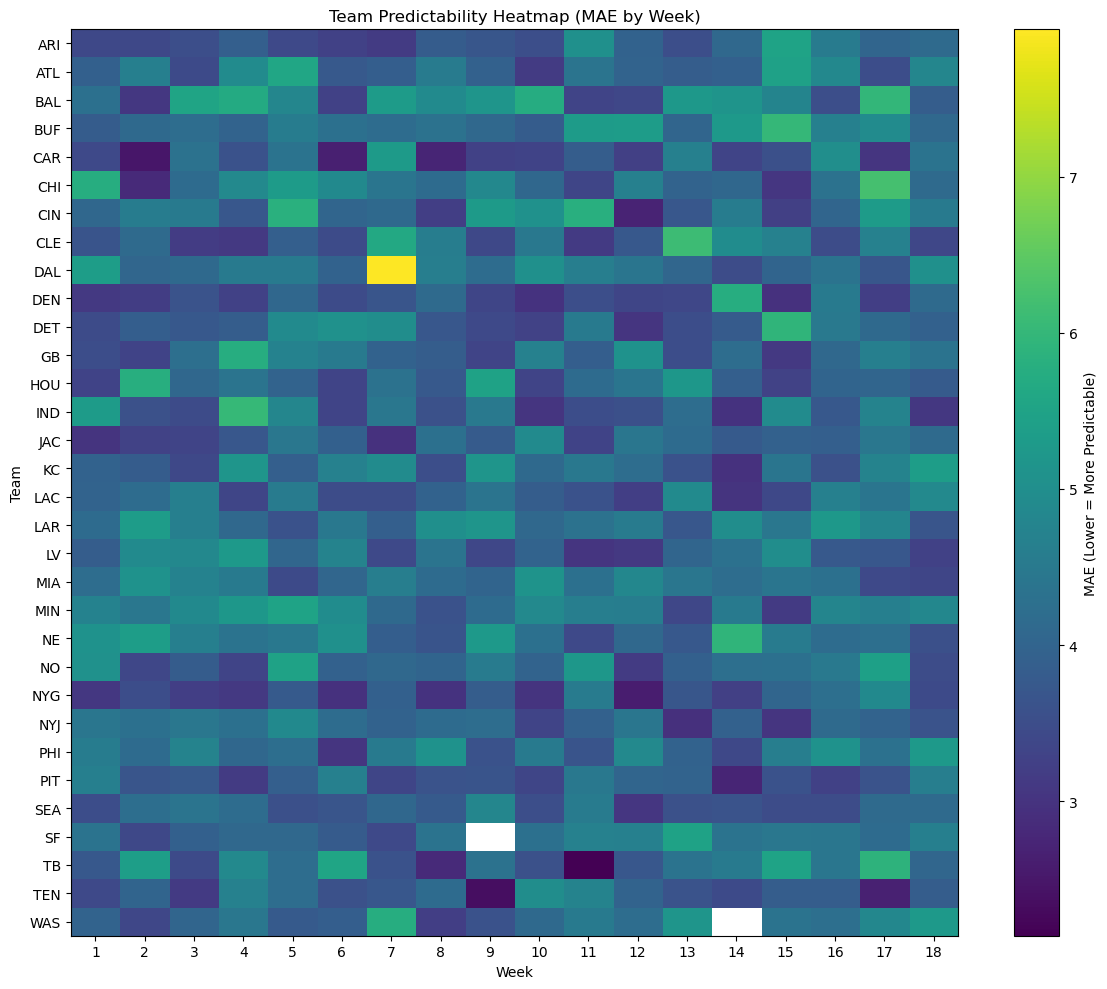

In [15]:
#looking at team bias & predictive visuals

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(team_stats["team"], team_stats["MAE"], color="steelblue")
plt.xticks(rotation=90)
plt.ylabel("MAE (Lower = More Predictable)")
plt.title("Team-Level Predictability (Mean Absolute Error)")
plt.tight_layout()
plt.show()



bias_sorted = team_stats.sort_values("Bias")

plt.figure(figsize=(12,6))
plt.bar(bias_sorted["team"], bias_sorted["Bias"], color="orange")
plt.xticks(rotation=90)
plt.axhline(0, color='black', linewidth=1)
plt.ylabel("Average Bias (Actual - Projected)")
plt.title("Team-Level Projection Bias")
plt.tight_layout()
plt.show()




team_week = df.groupby(["team", "week"])["abs_error"].mean().reset_index()
team_heatmap = team_week.pivot(index="team", columns="week", values="abs_error")

plt.figure(figsize=(12,10))
im = plt.imshow(team_heatmap, aspect="auto", cmap="viridis")
plt.colorbar(im, label="MAE (Lower = More Predictable)")

plt.title("Team Predictability Heatmap (MAE by Week)")
plt.xlabel("Week")
plt.ylabel("Team")

plt.xticks(ticks=np.arange(len(team_heatmap.columns)), labels=team_heatmap.columns)
plt.yticks(ticks=np.arange(len(team_heatmap.index)), labels=team_heatmap.index)

plt.tight_layout()
plt.show()

In [16]:
team_stats.sort_values("MAE").head(10)   # most predictable teams
team_stats.sort_values("MAE").tail(10)   # least predictable teams

team_stats.sort_values("Bias").head(10)  # most overprojected (underperformers)
team_stats.sort_values("Bias").tail(10)  # most underprojected (beat projections)

,team,MAE,RMSE,Bias,Count
20,MIN,4.513919,6.425915,0.365201,546
28,SF,4.276341,5.994742,0.365750,727
2,BAL,4.551930,6.333888,0.429474,570
14,JAC,3.876471,5.443732,0.471197,493
11,GB,4.111111,5.720116,0.540171,585
9,DEN,3.594571,5.220136,0.604378,571
27,SEA,3.878557,5.641688,0.627835,485
6,CIN,4.350845,6.334879,0.685980,592
29,TB,4.326195,6.138145,0.755258,523
10,DET,4.072253,5.939876,0.770950,537


In [ ]:
Most predictable teams:

NYG, DEN, CAR, PIT, TEN, ARI, JAC, SEA, LAC
These teams stay within a tight error band (MAE ~3.5–4.0), meaning their weekly output matched projections closely.
 
Least predictable teams:
BAL, MIN, BUF, DAL, LAR
These had the highest MAE (~4.5–4.6), meaning they consistently broke the model, boom/bust weeks, unexpected roles, or lots of variance.

Teams that beat projections (underprojected):
DET, TB, CIN, SEA, DEN, GB, JAC, BAL
These teams overperformed relative to projections (positive bias). Detroit being the strongest "value" (Bias ~0.77).

Teams that UNDERperformed projections (overprojected):
TEN, KC, WAS, ATL, LV, MIA
Tennessee was the MOST overprojected (Bias ~−0.39). Analysts consistently expected more than they delivered.

MOST PREDICTABLE TEAMS (Top 10 Lowest MAE)
Team-MAE
NYG-3.52
DEN-3.59
CAR-3.64
PIT-3.77
TEN-3.78
ARI-3.87
JAC-3.87
SEA-3.88
LAC-3.98
LV-3.99

LEAST PREDICTABLE TEAMS (Highest MAE)
Team-MAE
BAL-4.55
MIN-4.51
BUF-4.41
LAR-4.46
DAL-4.35

Why these teams break projections(possible):
BAL: Highly game-script dependent + rushing QB + unpredictable TD distribution
MIN: Jefferson injury chaos, role volatility
BUF: Spread offense, Allen volatility, TDs spread around
DAL: Huge swings (Pollard, Lamb, blowouts)
RAM:Injuries + McVay rotation randomness



TEAMS THAT MOST OUTPERFORMED PROJECTIONS (Underprojected)
Team-Bias (Actual – Projected)
DET+0.77
TB+0.75
CIN+0.63
SEA+0.62
DEN+0.60
GB+0.54
BAL+0.43
JAC+0.47


Teams like DET, SEA, and CIN are GREAT fantasy offenses because they’re consistently better than expected.

TEAMS THAT MOST UNDERPERFORMED PROJECTIONS (Overprojected)
Team-Bias
TEN−0.39
KC−0.33
WAS−0.30
ATL−0.20
LV−0.06
MIA−0.04

KC note: This matches the real trend, Mahomes’ passing TDs down, fantasy WR chaos.


Teams with stable low MAE:
NYG, DEN, CAR, PIT, JAC
No major spikes week-to-week
Predictable fantasy environments

Teams with MASSIVE volatility spikes:

DAL (Week 7 explosion)
SF (White gaps: missing or extreme outliers)
BAL, MIN (regular swings)
DET (late-season spike around Week 14–16)



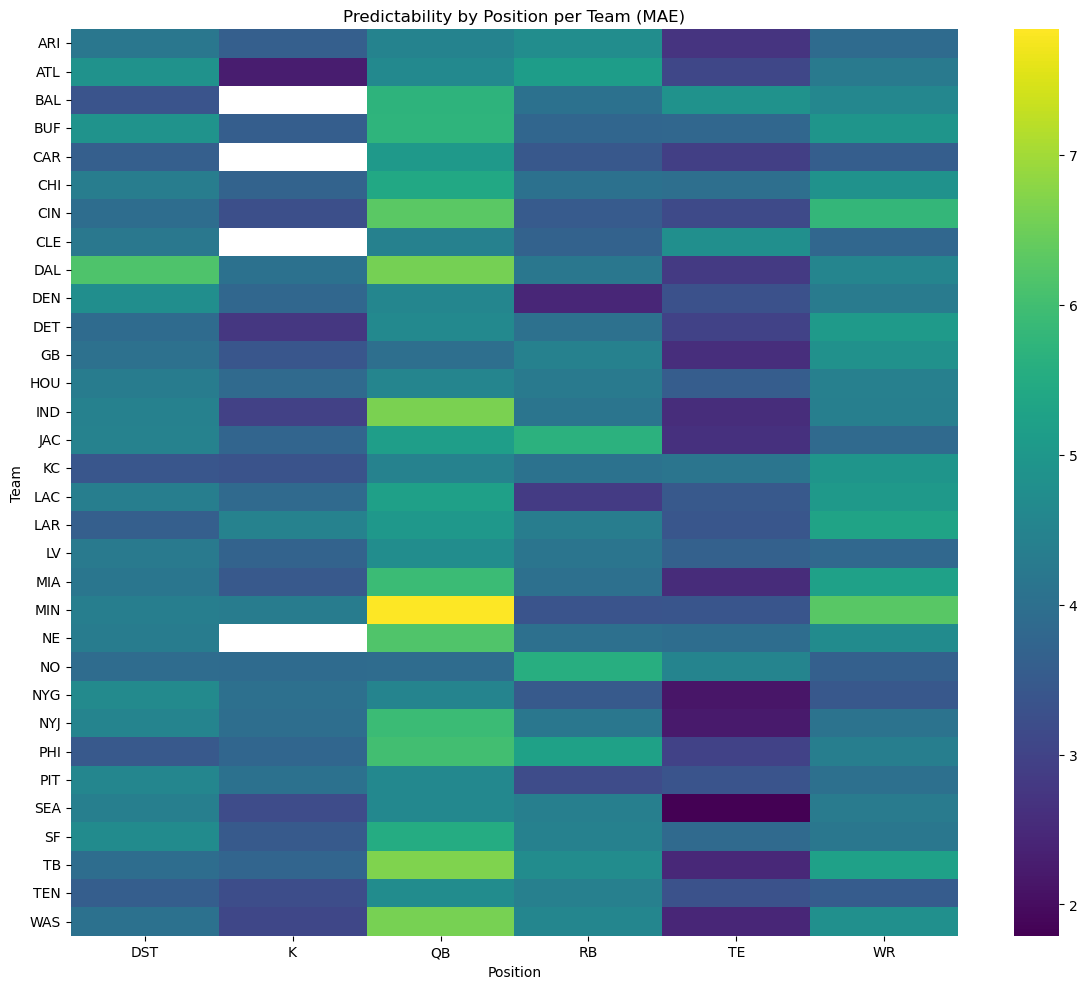

In [18]:
# --- Predictability by Position per Team ---
pos_team_stats = (
    df.groupby(["team", "position"])
      .agg(MAE=("abs_error", "mean"),
           RMSE=("sq_error", lambda x: np.sqrt(x.mean())),
           Bias=("error", "mean"),
           Count=("error", "count"))
      .reset_index()
)

# Sort by highest MAE = most chaotic combinations
pos_team_stats.sort_values("MAE", ascending=False).head(20)

import seaborn as sns
pivot_pos_team = pos_team_stats.pivot(index="team", columns="position", values="MAE")

plt.figure(figsize=(12,10))
sns.heatmap(pivot_pos_team, cmap="viridis", annot=False)
plt.title("Predictability by Position per Team (MAE)")
plt.xlabel("Position")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

In [ ]:
Most Chaotic QB Situations

Teams with brightest/yellow QB cells:

MIN – Chaotic QB
MAE near 7–8, extremely unstable
MIA – Chaotic QB

High MAE: Tua + explosive WR-driven variance
When Tyreek/Waddle erupt - projections break

SF – Chaotic QB
High efficiency but hard to project which Purdy games explode
McCaffrey games depress QB scoring unpredictably

Most Predictable QB Situations
NYJ

MAE low - consistent garbage production is predictable

Their QB room produces the same flat line every week

NYG

Another low-ceiling, easy-to-project QB situation

WR Stability vs Chaos
Chaotic WR rooms

Teams with high MAE for WR:

CHI – DJ Moore boom/bust + bad QB play
MIA – Tyreek volatility drives WR projections out of range
MIN – Jefferson absence - chaos between Addison, Osborn, Hockenson
JAC – Ridley/Christian Kirk/Zay Jones rotation makes predictions hard
DAL – CeeDee stable but WR2/TE rotations blow up projections

Predictable WR rooms
GB – young receivers, but surprisingly stable
LV – Adams dominates usage, steady WR volume
DET – ARSB + consistent scheme

RB Predictability Patterns
Stable RB teams

CAR - Low efficiency but predictable opportunity
JAC - Etienne dominates usage

Chaotic RB teams

SF - Usually predictable, but McCaffrey injuries/random usage elevate MAE
NO - Kamara/Jamaal/Kendre rotation
MIN - No clear RB1 period → chaos

TE Predictability
Most Predictable

CAR
SEA
GB

These teams tend to have a single TE with consistent usage.

Most Unpredictable

MIN - Hockenson volatility + injury games
NO - Multiple random TE usage patterns
SF - Kittle boom/bust weeks break projections
DST Predictability


Top predictable DST teams:

CAR
NYG
DEN
CIN

Most chaotic DST:

DAL - turnover/TD scoring volatility
SEA - inconsistent pressure
MIA -injury-driven variance

